In [1]:
import threading

import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import movecolumn as mc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
from nltk.stem import PorterStemmer
import nltk
from typing import List
from collections import Counter
from itertools import chain


plt.rcParams['figure.figsize'] = [14, 3]


# Предобработка данных

In [2]:
raw_df = pd.read_csv('data/SMS.tsv', sep='\t')
raw_df

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Соберём словарь

In [3]:
def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

vocab = build_vocab(raw_df.text)
print(len(vocab))
vocab.most_common(30)

15691


[('to', 2145),
 ('you', 1626),
 ('I', 1469),
 ('a', 1337),
 ('the', 1207),
 ('and', 858),
 ('in', 800),
 ('is', 788),
 ('i', 748),
 ('u', 698),
 ('for', 650),
 ('my', 630),
 ('of', 592),
 ('me', 561),
 ('your', 561),
 ('on', 488),
 ('have', 477),
 ('2', 457),
 ('that', 422),
 ('it', 397),
 ('are', 397),
 ('call', 376),
 ('or', 373),
 ('be', 363),
 ('at', 360),
 ('with', 351),
 ('not', 344),
 ('will', 333),
 ('get', 326),
 ('can', 304)]

Ну. так. не. пойдёт..., надо всё привести к начальной форме, нижнему регистру, убрать знаки всякие, стоп-слова....

In [4]:
nltk.download('stopwords')


def preprocess_text(text: str) -> str:
    # нижний регистр
    text = text.lower()
    
    # Убираем знаки всякие
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    # Убираем стоп слова
    eng_stopwords = set(stopwords.words('english'))
    is_NOT_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_NOT_stopword, text.split())))

    stemmer = PorterStemmer()
    text = ' '.join(list(map(stemmer.stem, text.split())))
    # Начальный форма
    return text

texts = []
for text in tqdm(raw_df.text.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(30)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\btima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 5572/5572 [00:01<00:00, 3141.77it/s]

7170


[('u', 1156),
 ('call', 658),
 ('im', 477),
 ('go', 456),
 ('get', 451),
 ('ur', 390),
 ('come', 300),
 ('dont', 298),
 ('ok', 278),
 ('free', 278),
 ('ltgt', 276),
 ('know', 270),
 ('like', 257),
 ('day', 256),
 ('love', 249),
 ('want', 245),
 ('ill', 245),
 ('got', 240),
 ('time', 239),
 ('good', 237),
 ('text', 225),
 ('send', 205),
 ('need', 187),
 ('one', 181),
 ('txt', 176),
 ('see', 172),
 ('today', 169),
 ('ü', 169),
 ('think', 166),
 ('stop', 163)]

In [5]:
texts[:30]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over',
 'u dun say earli hor u c alreadi say',
 'nah dont think goe usf live around though',
 'freemsg hey darl week word back id like fun still tb ok xxx std chg send rcv',
 'even brother like speak treat like aid patent',
 'per request mell mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun',
 'winner valu network custom select receivea prize reward claim call claim code kl valid hour',
 'mobil month u r entitl updat latest colour mobil camera free call mobil updat co free',
 'im gonna home soon dont want talk stuff anymor tonight k ive cri enough today',
 'six chanc win cash pound txt csh send cost pday day tsandc appli repli hl info',
 'urgent week free membership prize jackpot txt word claim tc wwwdbuknet lccltd pobox ldnwarw',
 'ive search

ну чё ещё за u, ur, im, call, go, get

Это стоп-слова датасета, НО удалять мы их не будем. Считаю, что эти слова тоже оказывают непосредственное влияние на классификацию спама. 

In [6]:
# for word, freq in vocab.most_common(10):
#     if word in vocab:  # чтобы код не сломался при повторном исполнении
#         vocab.pop(word)
        
# vocab.most_common(30)  

Датасет говно. 
Ну как, в целом СМСки это целая проблема, так как куча слов написано в гиперсокращённой форме, либо имеют тонну ошибок. И стандартные инструменты типо готового стеммера не очень-то с таким справляются
А в рандомной форме слова сложно анализировать....

Окей, словарь нам нужен был чисто для анализа качества фичаэкстрактинга. TfidfVectorizer в принципе сам для себя создаст свой словарь и векторизует с учётом частоты встречаемости токенов. Причём именно информативная часть этой метрики будет учтена. То есть выбросы частоты встречаемости будут именно там, где это является отличительной частотой документа. Всякие недоотсеянные стоп-слова не будут взрывать нам статистику.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer().fit(texts)

X = vectorizer.transform(texts).toarray()

print(X.shape)
vectorizer.inverse_transform(X)

(5572, 7150)


[array(['amor', 'avail', 'buffet', 'bugi', 'cine', 'crazi', 'go', 'got',
        'great', 'jurong', 'la', 'point', 'wat', 'world'], dtype='<U40'),
 array(['joke', 'lar', 'ok', 'oni', 'wif'], dtype='<U40'),
 array(['appli', 'comp', 'cup', 'entri', 'fa', 'final', 'free', 'may',
        'over', 'questionstd', 'ratetc', 'receiv', 'st', 'text', 'tkt',
        'txt', 'win', 'wkli'], dtype='<U40'),
 array(['alreadi', 'dun', 'earli', 'hor', 'say'], dtype='<U40'),
 array(['around', 'dont', 'goe', 'live', 'nah', 'think', 'though', 'usf'],
       dtype='<U40'),
 array(['back', 'chg', 'darl', 'freemsg', 'fun', 'hey', 'id', 'like', 'ok',
        'rcv', 'send', 'std', 'still', 'tb', 'week', 'word', 'xxx'],
       dtype='<U40'),
 array(['aid', 'brother', 'even', 'like', 'patent', 'speak', 'treat'],
       dtype='<U40'),
 array(['caller', 'callertun', 'copi', 'friend', 'mell', 'minnaminungint',
        'nurungu', 'oru', 'per', 'press', 'request', 'set', 'vettam'],
       dtype='<U40'),
 array(['call',

Ой, а это что тут у нас, X?
Неужели можно начинать заканчивать заниматься фигнёй и начать делать модельки

In [8]:
le = LabelEncoder().fit(raw_df["class"])
print(list(le.classes_))
Y = le.transform(raw_df["class"])
print(Y.shape)
Y

['ham', 'spam']
(5572,)


array([0, 0, 1, ..., 0, 0, 0])

In [20]:
train_features, test_features, train_target, test_target = train_test_split(X, Y, test_size=0.5, random_state=0)

print(train_features.shape)
print(train_target.shape)

print(test_features.shape)
print(test_target.shape)

(2786, 7150)
(2786,)
(2786, 7150)
(2786,)


In [21]:
from sklearn.metrics import roc_auc_score, classification_report

In [22]:
def stat_visualize(predictions, test):
    predictions = pd.Series(predictions)
    fig, ax = plt.subplots()
    ax.hist(test, bins=3, fc=(0, 1, 0, 1.0))
    ax.hist(predictions, bins=3, fc=(0, 0, 1, 0.5))

In [23]:
def indexed_features_sorted(feature_importances):
    indexed = list(zip(vectorizer.get_feature_names_out(), feature_importances))
    indexed.sort(key = lambda x: x[1], reverse=True)
    return np.array(indexed)

In [77]:
def named_features_to_idx(features, input_features):
    features_idx = {}
    for idx, name in enumerate(input_features):
        features_idx[name] = idx 
    named = list(map(lambda i: features_idx[i if isinstance(i, str) else i[0]], features))
    res = np.array(named)
    return res

In [36]:
def visualize(model, train_x, train_y, test_x, test_y):
    model = model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    score = roc_auc_score(test_y, y_pred, average='weighted')
    print(score)
    print(classification_report(test_y, model.predict(test_x)))
    stat_visualize(model.predict(test_x), test_y)

# Embedded

Возьмём RandomForestClassifier. 
Как и говорилось на лекции, он "из коробки" умеет выдавать фичи в порядке их "важности".
Важность их определяется положением в дереве. Чем выше, тем круче фича. 

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [30]:
from sklearn.ensemble import RandomForestClassifier


class RFCSelector:
    def __init__(self, n_features=30, threshold=1e-4, min_reduce=10, **kwargs):
        self.n_features = n_features
        self.threshold = threshold
        self.min_reduce = min_reduce
        self.forest = RandomForestClassifier(**kwargs)
        self.features = None
    
    def fit(self, x, y):
        fit = self.forest.fit(x, y)
        importances = fit.feature_importances_
        feature_idx = np.arange(importances.shape[0])
        while len(importances) > self.n_features:
            indexed = list(enumerate(importances))
            indexed.sort(key = lambda x: x[1], reverse=True)
            new_indexed = list(filter(lambda i: i[1] > self.threshold, indexed))
            if len(new_indexed) < self.n_features or len(indexed) - len(new_indexed) < self.min_reduce:
                new_indexed = indexed[:max(self.n_features, len(indexed) - self.min_reduce)]
            
            idx = list(list(zip(*new_indexed))[0])
            print(len(feature_idx), len(idx))
            feature_idx = feature_idx[idx]
            new_x = x[:, idx]
            fit = self.forest.fit(new_x, y)
            importances = fit.feature_importances_
        self.features = list(zip(feature_idx, importances))
        return self
    
    def get_feature_names_out(self, input_features=None):
        named = list(map(lambda i: (input_features[i[0]], i[1]), self.features))
        named.sort(key = lambda x: x[1], reverse=True)
        res = np.array(named)
        return res


rfc = RFCSelector(threshold=4e-3, n_features=32).fit(X, Y)
rfc_features = rfc.get_feature_names_out(vectorizer.get_feature_names_out())
rfc_features

7150 41
41 31
31 30


array([['cash', '0.28582348452791906'],
       ['video', '0.24087240049301026'],
       ['stop', '0.08773830222974882'],
       ['messag', '0.07962488527563133'],
       ['custom', '0.07433093474219049'],
       ['new', '0.050291192524334935'],
       ['box', '0.04853919358448678'],
       ['ur', '0.03800454544990408'],
       ['chat', '0.021568015887311942'],
       ['guarante', '0.008441104224990724'],
       ['tone', '0.00824756537725076'],
       ['mobil', '0.006216833259812012'],
       ['text', '0.006081036475003777'],
       ['txt', '0.005642253594839454'],
       ['contact', '0.004512484589381452'],
       ['urgent', '0.004120486790082129'],
       ['collect', '0.003919808838192149'],
       ['uk', '0.0022030894097124472'],
       ['per', '0.0021788612821560527'],
       ['free', '0.0021353561555944403'],
       ['rington', '0.0021259309611349397'],
       ['servic', '0.0020726343258604743'],
       ['pmin', '0.0020689592084629214'],
       ['call', '0.00205019644028901'],
    

Немногословно вышло))))
Всякие "claim prize" и прочий бред в топе, значит качество топ

# Wrapper

Будем обучать SVM, добавляя по одной фиче, пока добавление любой из фичей не начнёт ухудшать качество модели

In [13]:
from sklearn.svm import SVC
import threading


class SVM_SFS:
    def __init__(self, max_features=None, min_quality_increase=0.0, num_threads=1, **kwargs):
        self.max_features = max_features
        self.min_quality_increase = min_quality_increase
        self.model = SVC(class_weight='balanced', **kwargs)
        self.features = []
        self.num_threads = num_threads
        
    def fit(self, x, y):
        train_features, test_features, train_target, test_target = train_test_split(x, y, test_size=0.5, random_state=0)

        n_features = x.shape[1]

        last_score = 0.0
        cur_features = []
        while self.max_features is None or len(cur_features) < self.max_features:
            best_feature = [None for _ in range(self.num_threads)]
            best_score = [last_score for _ in range(self.num_threads)]
            threads = []
            for thread in range(self.num_threads):
                def routine(thread_id=thread, best_score=best_score, best_feature=best_feature):
                    for i in range(thread, n_features, self.num_threads):
                        if i in cur_features:
                            continue
                        fit = self.model.fit(train_features[:, cur_features + [i]], train_target)
                        y_pred = fit.predict(test_features[:, cur_features + [i]])
                        score = roc_auc_score(test_target, y_pred, average='weighted')
                        # print("delta", score - best_score[thread_id])
                        if score - best_score[thread_id] > self.min_quality_increase:
                            best_feature[thread_id] = i
                            best_score[thread_id] = score
                threads.append(threading.Thread(target=routine))
                threads[-1].start()
            for i in threads:
                i.join()
            real_best_feature = None
            real_best_score = last_score
            for i in range(self.num_threads):
                if best_feature[i] is not None:
                    if real_best_feature is None:
                        real_best_feature = best_feature[i]
                    real_best_feature = max(real_best_feature, best_feature[i])
                    real_best_score = max(real_best_score, best_score[i])
            if real_best_feature is None:
                break
            cur_features.append(real_best_feature)
            self.features.append((real_best_feature, real_best_score - last_score))
            print(real_best_feature, real_best_score - last_score)
            last_score = real_best_score
        return self
    
    def get_feature_names_out(self, input_features=None):
        named = list(map(lambda i: (input_features[i[0]], i[1]), self.features))
        named.sort(key = lambda x: x[1], reverse=True)
        res = np.array(named)
        return res


sfs = SVM_SFS(num_threads=20).fit(X, Y)
sfs.get_feature_names_out(vectorizer.get_feature_names_out())

7122 0.6040574578062083
2178 0.024047748236570965
6509 0.07901476425736065
844 0.08532141531256243
6737 0.04284661735728357
6398 0.0036262386840678618
7016 0.018507582031584646
5787 0.0031510409229801306
6266 0.007897878173458772
6826 0.006100465488191431
6072 0.005481908787160372
6417 0.003505154639175334
6595 0.007337578890253327
6641 0.003505154639175223
6969 0.006925207756232732
3664 0.001797412685267119
6427 0.005127795070965502
6026 0.004773681354770631
5290 0.0023577119684723424
5092 0.0021515264014623225
6921 0.0023577119684722314
5956 0.0013536282377131226
4718 0.0027700831024931594
4602 0.0012685267155952973
5118 0.0027700831024930483
4224 0.0013850415512465242
6338 0.0019453408344520806
6001 0.0013850415512463021
3920 0.0013850415512467462
6243 0.002003598252277139
2053 0.0013850415512467462
4932 0.002003598252277361


array([['yr', '0.6040574578062083'],
       ['call', '0.08532141531256243'],
       ['ur', '0.07901476425736065'],
       ['week', '0.04284661735728357'],
       ['free', '0.024047748236570965'],
       ['xma', '0.018507582031584646'],
       ['tone', '0.007897878173458772'],
       ['video', '0.007337578890253327'],
       ['wwwclubzedcouk', '0.006925207756232732'],
       ['win', '0.006100465488191431'],
       ['text', '0.005481908787160372'],
       ['uk', '0.005127795070965502'],
       ['team', '0.004773681354770631'],
       ['txt', '0.0036262386840678618'],
       ['ufind', '0.003505154639175334'],
       ['voucher', '0.003505154639175223'],
       ['stop', '0.0031510409229801306'],
       ['prem', '0.0027700831024931594'],
       ['romcapspam', '0.0027700831024930483'],
       ['select', '0.0023577119684723424'],
       ['would', '0.0023577119684722314'],
       ['rington', '0.0021515264014623225'],
       ['rcv', '0.002003598252277361'],
       ['toilet', '0.00200359825227713

За 2.5 часа намайнили 32 фичи и выполнился критерий останова!
Насколько же точна была изначальная оценка в 30 слов!
И насколько же распараллеливание оказалось эффективным. Средняя по ядрам ЦП была 97%, сэкономили больше суток!

In [18]:
sfs_features = sfs.get_feature_names_out(vectorizer.get_feature_names_out())
sum(map(float, sfs_features[:, 1]))

0.9395470771339635

Ожидаем качество 0.939 от SVM с вытащенными фичами

# Filter

In [64]:
def _chi2(a, b):
    k1 = len(np.unique(a))
    k2 = len(np.unique(b))
    n = a.shape[0]
    
    stat_x1 = [0 for _ in range(k1)]
    stat_x2 = [0 for _ in range(k2)]
    stat_x2_pref_sum = [0 for _ in range(k2)]
    overall_stat = {}
    for a_i, b_i in zip(a, b):
        stat_x1[a_i] += 1
        stat_x2[b_i] += 1
        if (a_i, b_i) not in overall_stat:
            overall_stat[(a_i, b_i)] = 0
        overall_stat[(a_i, b_i)] += 1
    
    stat_x2_pref_sum[0] = stat_x2[0]
    for i in range(1, k2):
        stat_x2_pref_sum[i] = stat_x2_pref_sum[i - 1] + stat_x2[i]
    
    x = list(overall_stat.keys())
    x.sort()
    
    ans = 0
    
    i0, j0 = x[0]
    if j0 > 0:
        ans += stat_x2_pref_sum[j0 - 1] * stat_x1[i0] / n
    
    for ni in range(len(x) - 1):
        i, j = x[ni]
        i1, j1 = x[ni + 1]
    
        e_ij = stat_x1[i] * stat_x2[j] / n
        r_ij = overall_stat[(i, j)]
        ans += ((e_ij - r_ij) ** 2) / e_ij
    
        if i1 == i:
            assert j1 > 0
            ans += (stat_x2_pref_sum[j1-1] - stat_x2_pref_sum[j]) * stat_x1[i] / n  # [i][j+1 .. j1-1]
        else:
            ans += (stat_x2_pref_sum[k2-1] - stat_x2_pref_sum[j]) * stat_x1[i] / n  # [i][j+1 .. k2-1] + [i1][0 .. j1-1]
            if j1 > 0:
                ans += stat_x2_pref_sum[j1-1] * stat_x1[i1] / n
    
    i_n, j_n = x[len(x) - 1]
    
    e_ij = stat_x1[i_n] * stat_x2[j_n] / n
    r_ij = overall_stat[(i_n, j_n)]
    ans += ((e_ij - r_ij) ** 2) / e_ij
    
    ans += (stat_x2_pref_sum[k2-1] - stat_x2_pref_sum[j_n]) * stat_x1[i_n] / n
    return ans


class XiSquaredSelector:
    def __init__(self, threshold=0., max_features=None):
        self.threshold = threshold
        self.max_features = max_features
        self.features = None

    def fit(self, x, y):
        chi2 = []
        for i in range(x.shape[1]):
            chi2.append(_chi2(x[:, i].astype(np.int64), y.astype(np.int64)))
        features = list(filter(lambda i: i[1] >= self.threshold, enumerate(chi2)))
        features.sort(key = lambda x: x[1], reverse=True)
        self.features = features[:self.max_features]
        return self
    
    def get_feature_names_out(self, input_features=None):
        named = list(map(lambda i: (input_features[i[0]], i[1]), self.features))
        named.sort(key = lambda x: x[1], reverse=True)
        res = np.array(named)
        return res


chi2 = XiSquaredSelector(max_features=32).fit(X, Y)
chi2_features = chi2.get_feature_names_out(vectorizer.get_feature_names_out())
chi2_features

array([['ringtonek', '6.460329440781134'],
       ['tfp', '6.460329440781134'],
       ['ok', '3.4195116650329087'],
       ['oki', '1.0850937530550397'],
       ['wat', '0.7747885159679868'],
       ['call', '0.4647061592810682'],
       ['come', '0.4647061592810682'],
       ['late', '0.4647061592810682'],
       ['sent', '0.4647061592810682'],
       ['talk', '0.4647061592810682'],
       ['yup', '0.4647061592810682'],
       ['doinghow', '0.3097484860605948'],
       ['see', '0.3097484860605948'],
       ['way', '0.3097484860605948'],
       ['alrit', '0.15484644295077304'],
       ['anyth', '0.15484644295077304'],
       ['anytim', '0.15484644295077304'],
       ['beerag', '0.15484644295077304'],
       ['buy', '0.15484644295077304'],
       ['channel', '0.15484644295077304'],
       ['check', '0.15484644295077304'],
       ['contin', '0.15484644295077304'],
       ['creep', '0.15484644295077304'],
       ['done', '0.15484644295077304'],
       ['earli', '0.15484644295077304'],
  

# Библиотечный Filter (ANOVA F-value) 

In [48]:
from sklearn.feature_selection import f_classif, GenericUnivariateSelect

selector = GenericUnivariateSelect(f_classif, mode='k_best', param=32)
fit = selector.fit(X, Y)
lib_f_classif_features = fit.get_feature_names_out(vectorizer.get_feature_names_out())
lib_f_classif_features

array(['award', 'box', 'call', 'cash', 'claim', 'code', 'collect',
       'contact', 'custom', 'draw', 'free', 'guarante', 'landlin',
       'latest', 'mobil', 'nokia', 'per', 'pobox', 'ppm', 'prize', 'rate',
       'repli', 'rington', 'servic', 'stop', 'tc', 'text', 'tone', 'txt',
       'urgent', 'voucher', 'win'], dtype=object)

# Библиотечный Embedded на деревьях

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
fit = clf.fit(X, Y)
model = SelectFromModel(fit, max_features=32, prefit=True).fit(X, Y)
lib_embedded_features = model.get_feature_names_out(vectorizer.get_feature_names_out())
lib_embedded_features

array(['award', 'call', 'claim', 'code', 'contact', 'free', 'guarante',
       'landlin', 'mob', 'mobil', 'new', 'nokia', 'per', 'pmin', 'pobox',
       'ppm', 'prize', 'rate', 'repli', 'rington', 'servic', 'stop', 'tc',
       'text', 'tone', 'tsc', 'txt', 'unsubscrib', 'urgent', 'video',
       'voucher', 'win'], dtype=object)

# Библиотечный Wrapper (RFE (Recursive Feature Elimination))

In [62]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=32, step=223, verbose=1)
fit = selector.fit(X, Y)
lib_rfe_features = fit.get_feature_names_out(vectorizer.get_feature_names_out())
lib_rfe_features

Fitting estimator with 7150 features.
Fitting estimator with 6927 features.
Fitting estimator with 6704 features.
Fitting estimator with 6481 features.
Fitting estimator with 6258 features.
Fitting estimator with 6035 features.
Fitting estimator with 5812 features.
Fitting estimator with 5589 features.
Fitting estimator with 5366 features.
Fitting estimator with 5143 features.
Fitting estimator with 4920 features.
Fitting estimator with 4697 features.
Fitting estimator with 4474 features.
Fitting estimator with 4251 features.
Fitting estimator with 4028 features.
Fitting estimator with 3805 features.
Fitting estimator with 3582 features.
Fitting estimator with 3359 features.
Fitting estimator with 3136 features.
Fitting estimator with 2913 features.
Fitting estimator with 2690 features.
Fitting estimator with 2467 features.
Fitting estimator with 2244 features.
Fitting estimator with 2021 features.
Fitting estimator with 1798 features.
Fitting estimator with 1575 features.
Fitting esti

array(['ac', 'alert', 'bx', 'cc', 'claim', 'deliveri', 'eg', 'expir',
       'filthi', 'immedi', 'ltd', 'mob', 'pmin', 'pmsg', 'pobox',
       'privat', 'quiz', 'ralli', 'rate', 'rington', 'santa', 'servic',
       'subpoli', 'tc', 'tsc', 'txt', 'uk', 'unsubscrib', 'video',
       'voicemail', 'wap', 'winner'], dtype=object)

# Сравниваем работу классификаторов до и после

### SVM

До:
0.9079687009166976
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2425
           1       0.99      0.82      0.90       361

    accuracy                           0.98      2786
   macro avg       0.98      0.91      0.94      2786
weighted avg       0.98      0.98      0.97      2786

Embedded:
0.910456635348545
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2425
           1       0.71      0.88      0.78       361

    accuracy                           0.94      2786
   macro avg       0.84      0.91      0.87      2786
weighted avg       0.95      0.94      0.94      2786

Wrapper:
0.9379558500157067
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2425
           1       0.66      0.95      0.78       361

    accuracy                           0.93      2786
   macro avg       0.82      0.94      0.87      

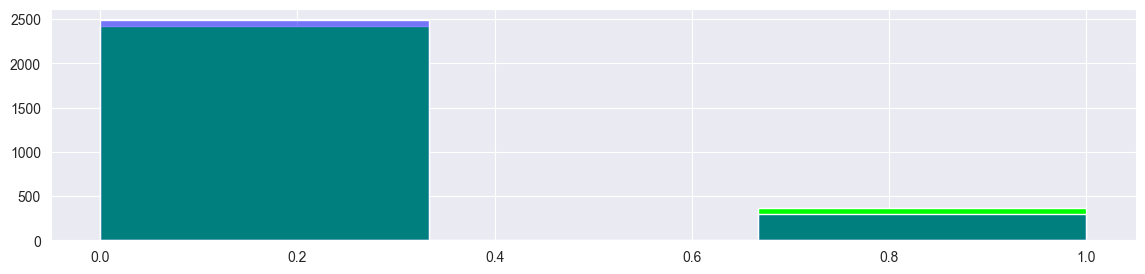

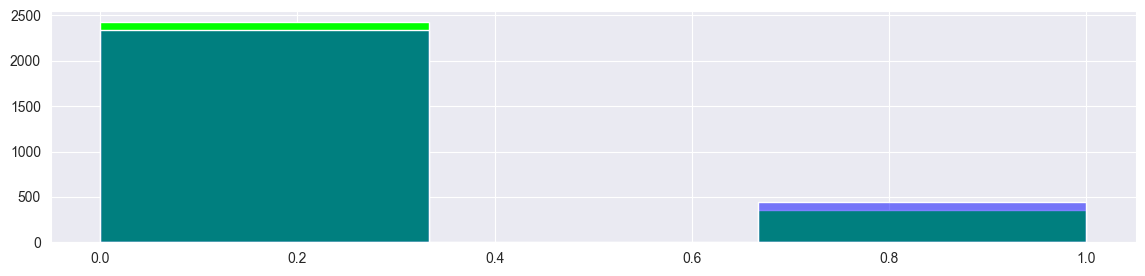

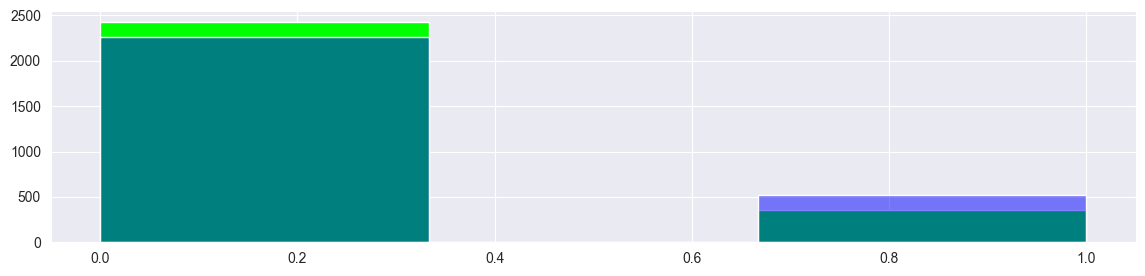

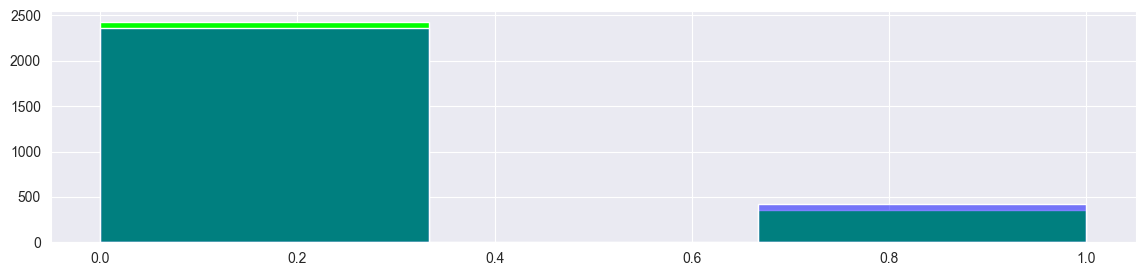

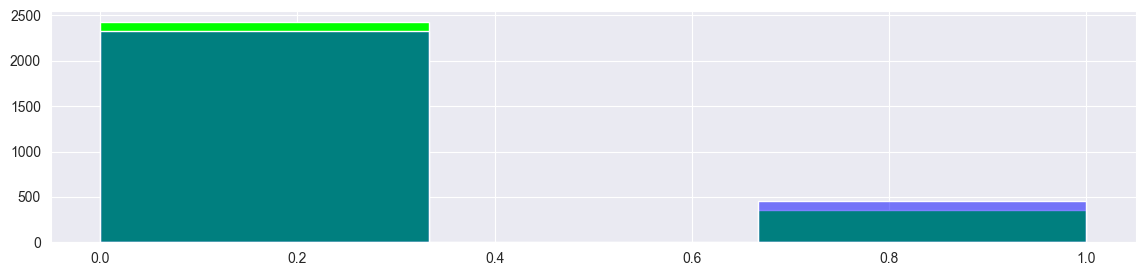

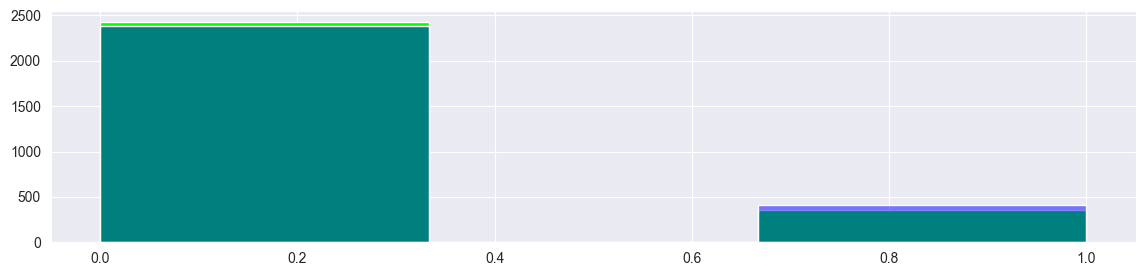

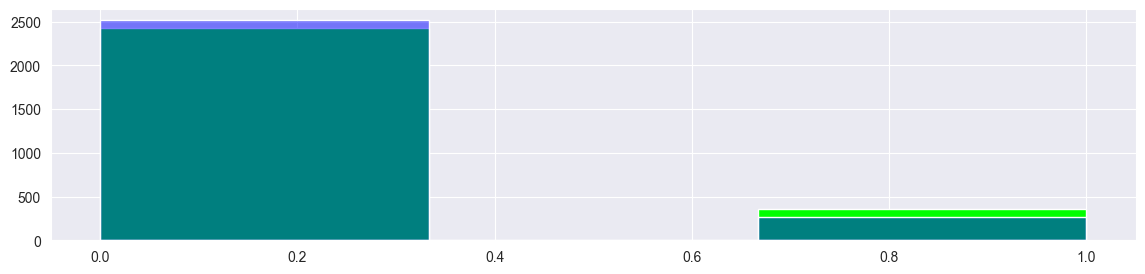

In [78]:
from sklearn.svm import SVC

print("До:")
visualize(SVC(class_weight='balanced'), train_features, train_target, test_features, test_target)

print("Embedded:")
feature_idx = named_features_to_idx(rfc_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Wrapper:")
feature_idx = named_features_to_idx(sfs_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Filter:")
feature_idx = named_features_to_idx(chi2_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Filter:")
feature_idx = named_features_to_idx(lib_f_classif_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Embedded:")
feature_idx = named_features_to_idx(lib_embedded_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Wrapper:")
feature_idx = named_features_to_idx(lib_rfe_features, vectorizer.get_feature_names_out())
visualize(SVC(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

2 минуты против 660 мс!
И при этом качество стало ещё круче

### KNN


До:
0.6202924293914385
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2425
           1       0.99      0.24      0.39       361

    accuracy                           0.90      2786
   macro avg       0.94      0.62      0.67      2786
weighted avg       0.91      0.90      0.87      2786

Embedded:
0.8477082559899477
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2425
           1       0.87      0.71      0.78       361

    accuracy                           0.95      2786
   macro avg       0.91      0.85      0.88      2786
weighted avg       0.95      0.95      0.95      2786

Wrapper:
0.8541942485078676
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2425
           1       0.79      0.74      0.76       361

    accuracy                           0.94      2786
   macro avg       0.88      0.85      0.87     

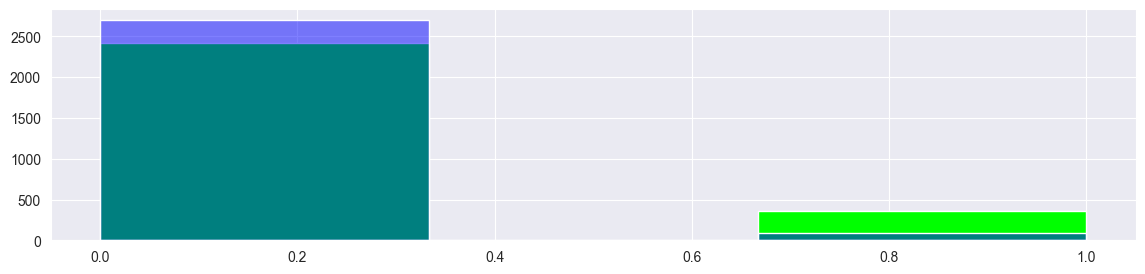

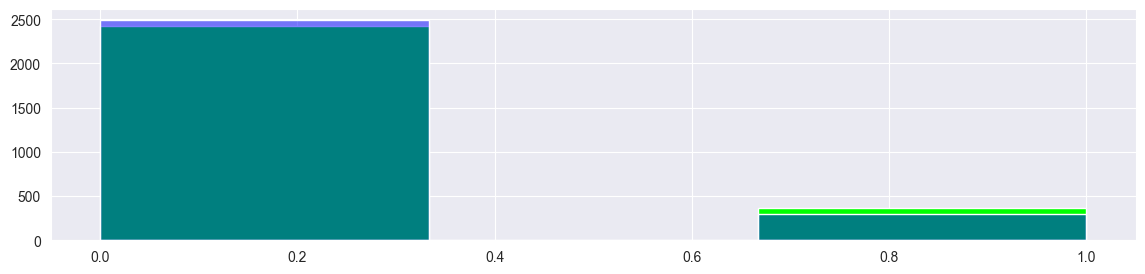

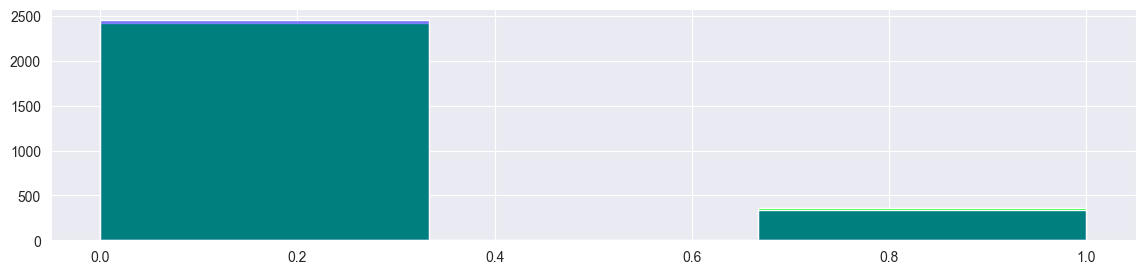

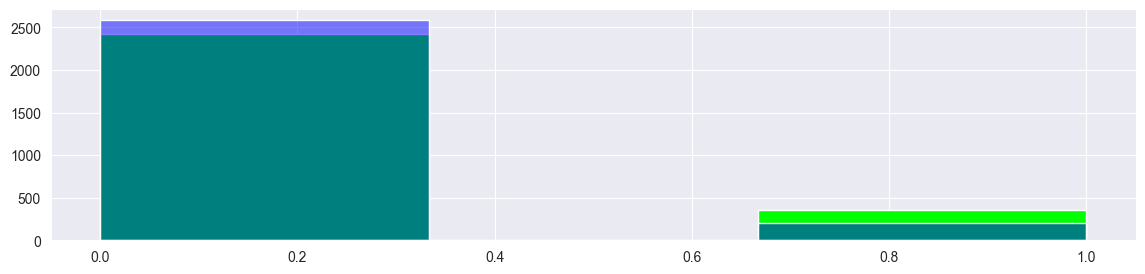

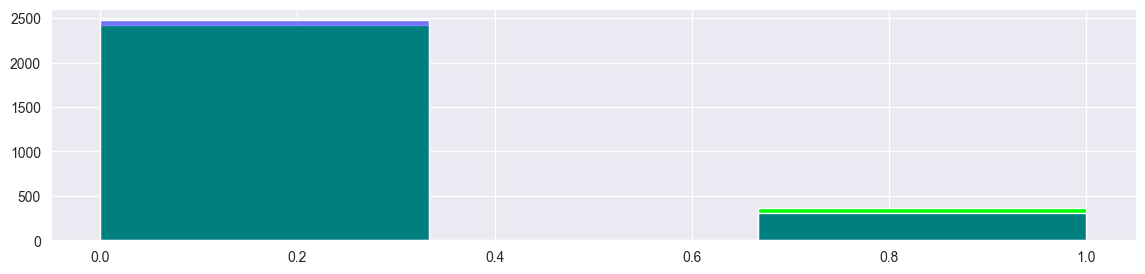

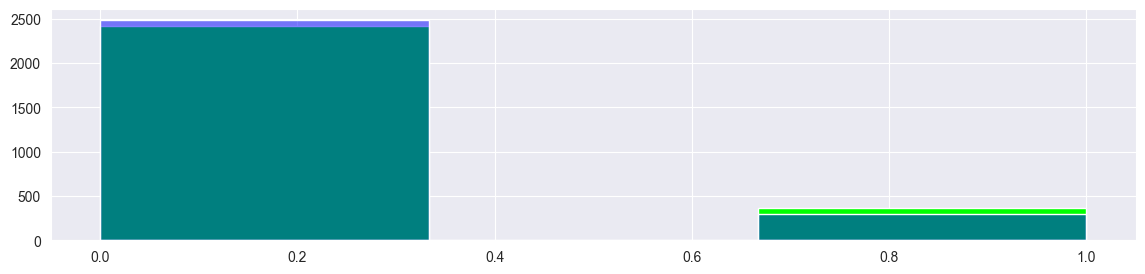

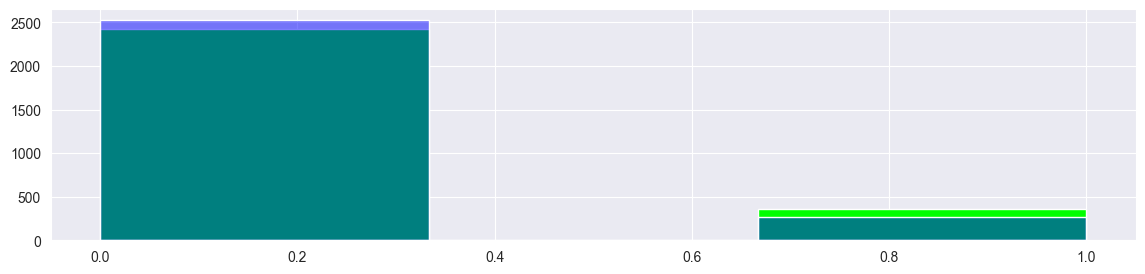

In [79]:
from sklearn.neighbors import KNeighborsClassifier

print("До:")
visualize(KNeighborsClassifier(), train_features, train_target, test_features, test_target)

print("Embedded:")
feature_idx = named_features_to_idx(rfc_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Wrapper:")
feature_idx = named_features_to_idx(sfs_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Filter:")
feature_idx = named_features_to_idx(chi2_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Filter:")
feature_idx = named_features_to_idx(lib_f_classif_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Embedded:")
feature_idx = named_features_to_idx(lib_embedded_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Wrapper:")
feature_idx = named_features_to_idx(lib_rfe_features, vectorizer.get_feature_names_out())
visualize(KNeighborsClassifier(), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

Охренеть, вот ЗДЕСЬ это реально сработало. Качество выросло на порядки

### Decision Tree

До:
0.9029397149955737
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2425
           1       0.74      0.85      0.79       361

    accuracy                           0.94      2786
   macro avg       0.86      0.90      0.88      2786
weighted avg       0.95      0.94      0.94      2786

Embedded:
0.8254042322300598
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2425
           1       0.75      0.68      0.72       361

    accuracy                           0.93      2786
   macro avg       0.85      0.83      0.84      2786
weighted avg       0.93      0.93      0.93      2786

Wrapper:
0.8282325727503784
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2425
           1       0.77      0.69      0.73       361

    accuracy                           0.93      2786
   macro avg       0.86      0.83      0.84     

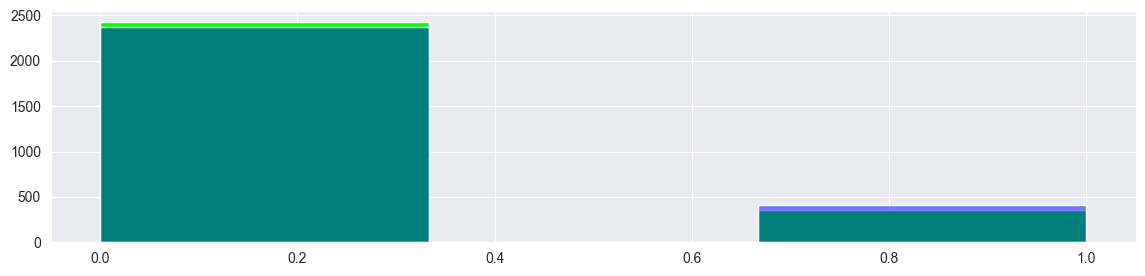

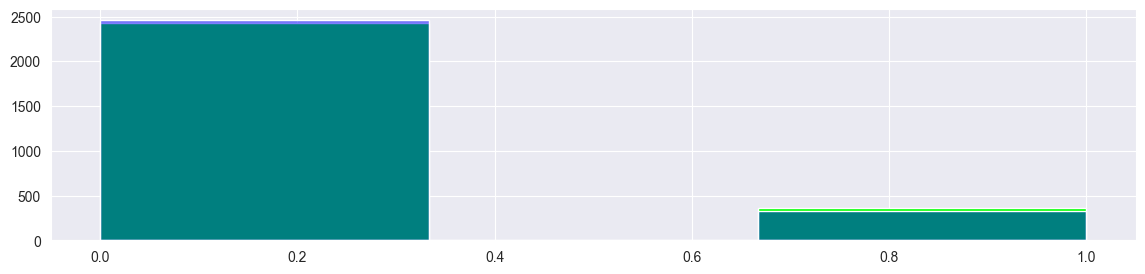

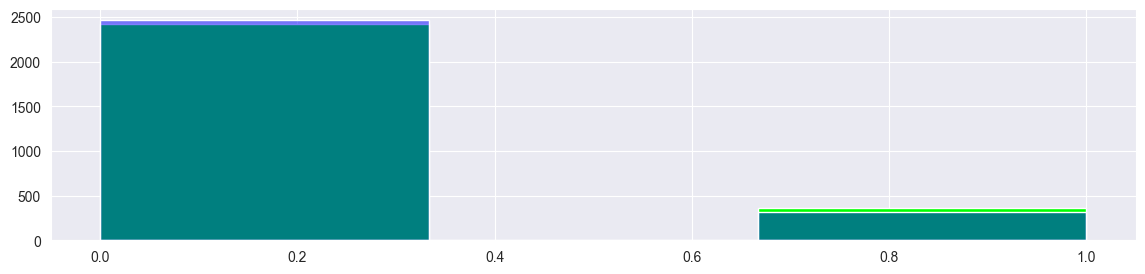

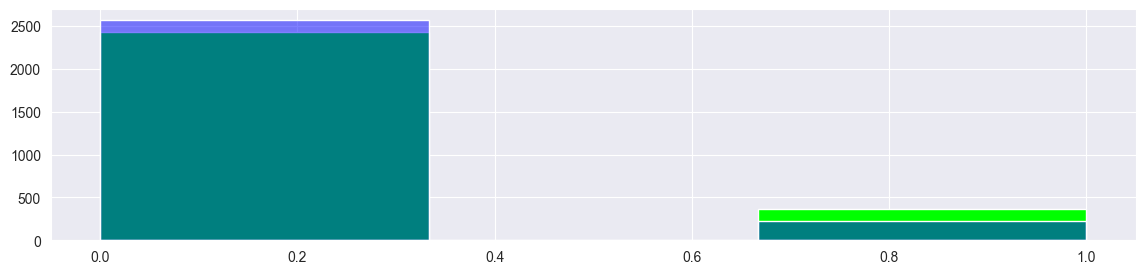

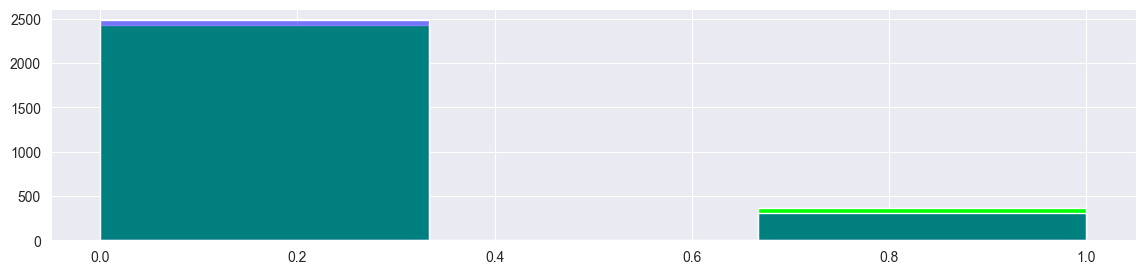

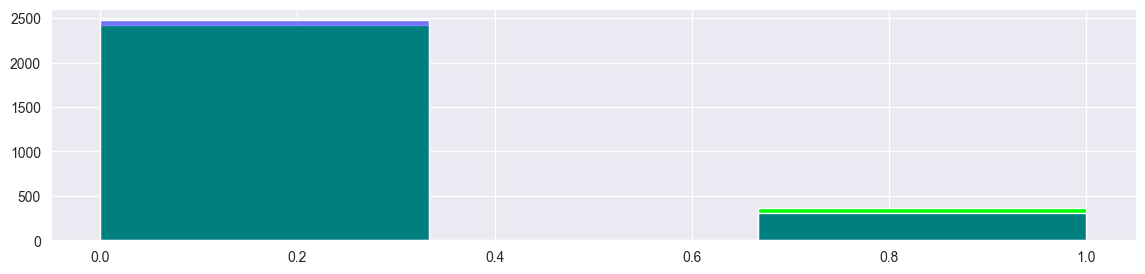

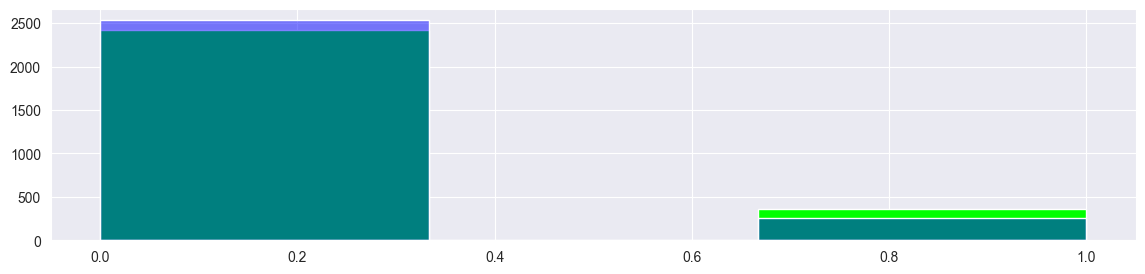

In [80]:
from sklearn.tree import DecisionTreeClassifier

print("До:")
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features, train_target, test_features, test_target)

print("Embedded:")
feature_idx = named_features_to_idx(rfc_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Wrapper:")
feature_idx = named_features_to_idx(sfs_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Filter:")
feature_idx = named_features_to_idx(chi2_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Filter:")
feature_idx = named_features_to_idx(lib_f_classif_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Embedded:")
feature_idx = named_features_to_idx(lib_embedded_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

print("Lib Wrapper:")
feature_idx = named_features_to_idx(lib_rfe_features, vectorizer.get_feature_names_out())
visualize(DecisionTreeClassifier(class_weight='balanced'), train_features[:, feature_idx], train_target, test_features[:, feature_idx], test_target)

Ожидаемо, для DecisionTree качество ухудшилось, но ускорилось время работы. Потому что само по себе это дерево очень неплохо выбирает признаки без нашей помощи, а мы ему щас мешаем

Все ожидания подтвердились, топчик
Все классификаторы в Wrapper отработали на несколько процентов лучше, чем в Embedded методе

# Сравнение выбранных фичей для каждого из алгоритмов

In [89]:
df_rfc = pd.DataFrame({'RFC': True, 'name': rfc_features[:, 0]})
df_sfs = pd.DataFrame({'SFS': True, 'name': sfs_features[:, 0]})
df_chi2 = pd.DataFrame({'Chi2': True, 'name': chi2_features[:, 0]})
df_lib_f_classif = pd.DataFrame({'Lib F-Classif': True, 'name': lib_f_classif_features})
df_lib_embedded = pd.DataFrame({'Lib Embedded': True, 'name': lib_embedded_features})
df_lib_rfe = pd.DataFrame({'Lib RFE': True, 'name': lib_rfe_features})

df = pd.merge(df_rfc, df_sfs, left_on=['name'], right_on=['name'], how='outer')
df = pd.merge(df , df_chi2, left_on=['name'], right_on=['name'], how='outer')
df = pd.merge(df , df_lib_f_classif, left_on=['name'], right_on=['name'], how='outer')
df = pd.merge(df , df_lib_embedded, left_on=['name'], right_on=['name'], how='outer')
df = pd.merge(df , df_lib_rfe, left_on=['name'], right_on=['name'], how='outer')

df = df.fillna(False)
df.insert(0, 'name', df.pop('name'))
df['Occurrence count']= df.iloc[:, 1:].sum(axis=1)
df = df.sort_values('Occurrence count', ascending=False)

df

,name,RFC,SFS,Chi2,Lib F-Classif,Lib Embedded,Lib RFE,Occurrence count
23,call,True,True,True,True,True,False,5
20,rington,True,True,False,True,True,True,5
13,txt,True,True,False,True,True,True,5
22,pmin,True,True,False,False,True,True,4
19,free,True,True,False,True,True,False,4
...,...,...,...,...,...,...,...,...
54,wat,False,False,True,False,False,False,1
53,oki,False,False,True,False,False,False,1
52,ok,False,False,True,False,False,False,1
51,tfp,False,False,True,False,False,False,1
